In [1]:
### Import packages ###
import time, sys, os
import h5py
import numpy as np
import astropy as ap
import scipy
import pandas
from matplotlib.pyplot import *

# Import packages to display SDSS optical image
from PIL import Image
import requests

# Import packages to open fits and calculate cosmology
from astropy.io import fits
from astropy.cosmology import WMAP9
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.sdss import SDSS
from scipy.io import readsav

# Import prospector 
sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling
from prospect.models.templates import TemplateLibrary
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot
from prospect.fitting import fit_model
from prospect.io import write_results as writer
import prospect.io.read_results as reader

import corner

# Import MCMC package
import emcee

# Import my build functions
from build_model_funct import build_model
from build_obs_funct import build_obs
from FracSFH_ import FracSFH

import seaborn as sns
my_cmap = sns.color_palette("tab10")

### re-defining plotting defaults for matplotlib
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})
rcParams.update({'axes.facecolor':'w'})
rcParams.update({'savefig.facecolor':'w'})
rcParams.update({'lines.linewidth':'0.7'})

rcParams.update({'axes.prop_cycle': cycler(color = sns.color_palette("tab10"))})
%matplotlib inline

### package versions ###
# vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
# print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))
# rcParams.keys()

In [2]:
### Start Timer ###
start_time = time.time()

In [3]:
### Constants ###
lsun = 3.846e33
pc = 3.085677581467192e18 # in cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.0 * np.pi * (pc*10)**2)
jansky_mks = 1e-26

### My Unit Functions ###
def mJy_to_maggies(mJy):
    """ Converts mJy to maggies
    """
    conversion_mJy_Jy = .001
    conversion_mJy_maggie = 3631
    return mJy * conversion_mJy_Jy/conversion_mJy_maggie

def f_nu_to_f_lambda_maggie(lam, f_nu):
    """ Converts f_nu (ergs) to f_lambda (maggies)
    """
    f_lambda_ergs = (10**-17 * f_nu) * (lam**2)/lightspeed
    f_lambda_mJy = (f_lambda_ergs / (1E-23)) * 1000
    f_lambda_maggie = mJy_to_maggies(f_lambda_mJy)
    return f_lambda_maggie

### From GitHub ###
def get_best_v2(res, **kwargs):
    """ Get the maximum a posteriori parameters.
    """
    imax = np.argmax(res['lnprobability'])
    try:
        i, j = np.unravel_index(imax, res['lnprobability'].shape)
        theta = res['chain'][i, j, :].copy()
    except(ValueError):
        theta = res['chain'][imax, :].copy()
        
    return  theta

def build_sps(zcontinuous=1, **extras):
    """ Build sps object using FracSFH basis
    """
    sps = FracSFH(zcontinuous = 1, **extras)         # run_params
    return sps

def zfrac_to_masses(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to sfr
    fractions and then to bin mass fractions. The transformation is such that
    sfr fractions are drawn from a Dirichlet prior.  See Betancourt et al. 2010
    and Leja et al. 2017
    :param total_mass:
        The total mass formed over all bins in the SFH.
    :param z_fraction:
        latent variables drawn form a specific set of Beta distributions. (see
        Betancourt 2010)
    :returns masses:
        The stellar mass formed in each age bin.
    """
    # sfr fractions
    sfr_fraction = np.zeros(len(z_fraction) + 1)
    sfr_fraction[0] = 1.0 - z_fraction[0]
    for i in range(1, len(z_fraction)):
        sfr_fraction[i] = np.prod(z_fraction[:i]) * (1.0 - z_fraction[i])
    sfr_fraction[-1] = 1 - np.sum(sfr_fraction[:-1])

    # convert to mass fractions
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    mass_fraction = sfr_fraction * np.array(time_per_bin)
    mass_fraction /= mass_fraction.sum()

    masses = total_mass * mass_fraction
    return masses


def zfrac_to_sfr(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to SFRs.
    :returns sfrs:
        The SFR in each age bin (msun/yr).
    """
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    masses = zfrac_to_masses(total_mass, z_fraction, agebins)
    return masses / time_per_bin

def best_vals(result_list):
    # print(corner.quantile(result_list[param_order], [0.16, 0.5, 0.84]))
    q_16, q_50, q_84 = corner.quantile(result_list, [0.16, 0.5, 0.84]) 
    dx_down, dx_up = q_50-q_16, q_84-q_50
    # return (np.around(q_50,2), np.around(dx_up,2), np.around(dx_down,2))
    return q_50, dx_up, dx_down

print('Packages and Functions Loaded')

Packages and Functions Loaded


In [4]:
### Import full galaxy file (58 galaxies) ###
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

In [5]:
### Choose a galaxy (0 to 57) ###
galaxy_num = 37
Template_Type = 'alpha_agn'

# Create galaxy file to store plots and hdf5 data file
if not os.path.exists('Galaxy_output/G{}/'.format(galaxy_num)):
    os.mkdir('Galaxy_output/G{}/'.format(galaxy_num))
Galaxy_Path = 'Galaxy_output/G{}/'.format(galaxy_num)

print('This is for Galaxy ', galaxy_num + 1)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)
print('The template type is', Template_Type)

This is for Galaxy  38
The Date is 21Jul15
The template type is alpha_agn


In [6]:
### Query SDSS to get optical spectra data ###
#   Used tutorial from 
#       https://learn.astropy.org/rst-tutorials/User-Defined-Model.html 
#       http://astroweb.case.edu/jakub/TA/Interpolation.html 

# Pull RA, DEC from data file and query SDSS
Gal_RA, Gal_DEC = AGN_data[galaxy_num][2], AGN_data[galaxy_num][3]
pos = coord.SkyCoord(Gal_RA, Gal_DEC, unit='deg',frame='icrs')
xid = SDSS.query_region(pos, spectro=True)

/home/emma/.local/lib/python3.8/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [7]:
### Redefine RA, DEC ###
Gal_RA = xid['ra'][0]
Gal_DEC = xid['dec'][0]

### Redshift ###
# Use redshift from SDSS query
G_Redshift = xid['z'][0]

# Cosmological redshift object
cosmo = ap.cosmology.FlatLambdaCDM(H0=70 , Om0=0.3)       
# cosmological redshift 
ldist_Mpc_units = cosmo.comoving_distance(G_Redshift) 

# Get ldist in Mpc from ldist with units
ldist_Mpc = ldist_Mpc_units.value           
tage_of_univ = WMAP9.age(G_Redshift).value                  # Gyr

In [8]:
### Get optical spectrum from SDSS query ###
optical_spectrum = SDSS.get_spectra(plate= xid['plate'][0], fiberID= xid['fiberID'][0], mjd= xid['mjd'][0])[0] 

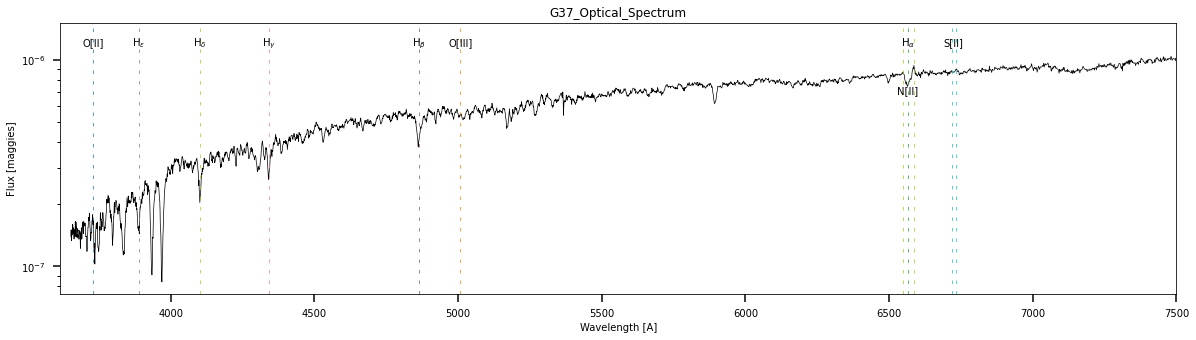

In [9]:
### Plot optical spectrum ###
optical_spectrum_flux = optical_spectrum[1].data['flux']
optical_spectrum_lam = 10 ** (optical_spectrum[1].data['loglam'])

# Find what units the data is in
units_flux = optical_spectrum[0].header['bunit']
units_wavelength_full = optical_spectrum[0].header['WAT1_001']
units_wavelength = units_wavelength_full[36:]

# Convert SDSS units to Prospector units
optical_spectrum_flux = f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux)       
optical_spectrum_lam = optical_spectrum_lam / (1 + G_Redshift)                                  # Rest Frame

# Plot the spectra
fig = figure(figsize=(20, 5))
plot(optical_spectrum_lam, optical_spectrum_flux, color='k')

# Spectra lines for OII, OIII, Hα, Hβ, Hγ, Hδ, NII, SII     
optical_spectrum_lines = optical_spectrum[3].data

ax = gca()
y_min, y_max = ax.get_ylim()
spec_lines = ['[O_II] 3727', '[O_III] 5007', 'H_alpha', '[N_II] 6548', '[N_II] 6583', 'H_beta', 'H_gamma', 'H_epsilon', 'H_delta', '[S_II] 6716', '[S_II] 6730']
spec_lines_short = [r'O[II]', r'O[III]', r'H$_α$', r'N[II]', r'N[II]', r'H$_β$', r'H$_γ$', r'H$_ε$', r'H$_δ$', r'S[II]', r'S[II]']
for i, n in enumerate(spec_lines):
    # print(n, " ->", optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n])
    if (n =='[N_II] 6548' or n =='[N_II] 6583'):
        axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n], label='{0}'.format(n), color=my_cmap[8], ymax = 1, ymin = 0, linestyle=(0, (5, 10))) 
        if n =='[N_II] 6548':
            annotate(spec_lines_short[i], ((6548 + 6583)/2, y_max* 0.5), horizontalalignment='center')
    elif (n =='[S_II] 6716' or n =='[S_II] 6730'):
        axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n], label='{0}'.format(n), color=my_cmap[9], ymax = 1, ymin = 0, linestyle=(0, (5, 10))) 
        if n == '[S_II] 6716':
            annotate(spec_lines_short[i], ((6716 + 6730)/2, y_max* 0.85), horizontalalignment='center')
    else:
        axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n], label='{0}'.format(n), color=my_cmap[i], ymax = 1, ymin = 0, linestyle=(0, (5, 10)))
        annotate(spec_lines_short[i], (optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n], y_max* 0.85), horizontalalignment='center')

xlim(min(optical_spectrum_lam) * .99, 7500)
xlabel('Wavelength [A]')
ylabel('Flux [maggies]')
title('G{0}_Optical_Spectrum'.format(galaxy_num))
yscale('log')
# legend(loc=1, fontsize=14)

In [10]:
# for i in range(len(optical_spectrum_lines)):
#     print(optical_spectrum_lines[i][3])

([<matplotlib.axis.YTick at 0x7fe07c7619d0>,
 [Text(0, 0.0, '2h47m23s'),
  Text(0, 64.0, '2h47m25s'),
  Text(0, 128.0, '2h47m27s')])

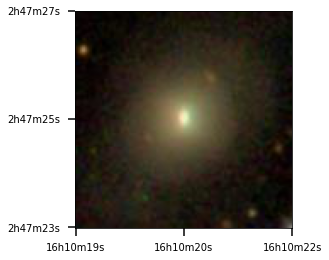

In [11]:
### Get optical image from the url using galaxy RA and DEC ###
SDSS_scale = 0.396127                   # arcsec/pix
SDSS_width = 128                        # SDSS_arcsec/SDSS_scale
SDSS_arcsec = SDSS_width * SDSS_scale   # arcsec 
SDSS_deg = SDSS_arcsec/3600             # deg

SDSS_URL = 'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.List&ra={0}&dec={1}&width={2}&height={2}&scale={3}'.format(Gal_RA, Gal_DEC, SDSS_width, SDSS_scale)

SDSS_Image = Image.open(requests.get(SDSS_URL, stream=True).raw)
imshow(SDSS_Image, origin='lower')


SDSS_center_coords = SkyCoord(ra=Gal_RA*u.degree, dec=Gal_DEC*u.degree)
SDSS_left_coords = SkyCoord(ra=Gal_RA*u.degree - (SDSS_deg/2) * u.deg, dec=Gal_DEC*u.degree - (SDSS_deg/2) * u.deg)
SDSS_right_coords = SkyCoord(ra=Gal_RA*u.degree + (SDSS_deg/2) * u.deg, dec=Gal_DEC*u.degree + (SDSS_deg/2) * u.deg)

ra_center_str = '{0:.0f}h{1:.0f}m{2:.0f}s'.format(SDSS_center_coords.ra.hms[0], SDSS_center_coords.ra.hms[1], SDSS_center_coords.ra.hms[2])
ra_left_str = '{0:.0f}h{1:.0f}m{2:.0f}s'.format(SDSS_left_coords.ra.hms[0], SDSS_left_coords.ra.hms[1], SDSS_left_coords.ra.hms[2])
ra_right_str = '{0:.0f}h{1:.0f}m{2:.0f}s'.format(SDSS_right_coords.ra.hms[0], SDSS_right_coords.ra.hms[1], SDSS_right_coords.ra.hms[2])

dec_center_str = '{0:.0f}h{1:.0f}m{2:.0f}s'.format(SDSS_center_coords.dec.hms[0], SDSS_center_coords.dec.hms[1], SDSS_center_coords.dec.hms[2])
dec_left_str = '{0:.0f}h{1:.0f}m{2:.0f}s'.format(SDSS_left_coords.dec.hms[0], SDSS_left_coords.dec.hms[1], SDSS_left_coords.dec.hms[2])
dec_right_str = '{0:.0f}h{1:.0f}m{2:.0f}s'.format(SDSS_right_coords.dec.hms[0], SDSS_right_coords.dec.hms[1], SDSS_right_coords.dec.hms[2])

xticks([0, SDSS_width/2, SDSS_width], labels=[ra_left_str, ra_center_str, ra_right_str])
yticks([0, SDSS_width/2, SDSS_width], labels=[dec_left_str, dec_center_str, dec_right_str])

In [12]:
### Spitzer IRS data from Dr. Smercina ###
ea_struct = readsav('Data/ea_struct_v9.sav')['ea_struct']
# ea_struct.dtype.names                                     # Keys in ea_struct

There is Spitzer IRS spectrum data for this galaxy
This is galaxy EAS11 37


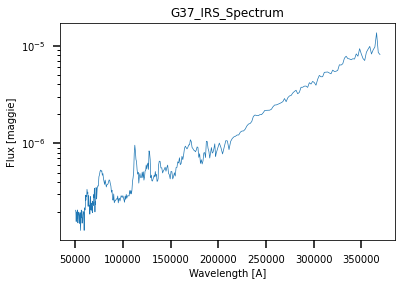

In [13]:
gal_desig = AGN_data[galaxy_num][1]
gal_EA_Desig = gal_desig[2:]
s1, = np.where(ea_struct.source.astype(str) == 'Spitzer')       # Pulls only spitzer from sources
ea_struct = ea_struct[s1]                                       # Masks ea_struct to get spitzer

# If the IRS data contains the galaxy, graph the IRS data. If not print there is no IRS data.
if gal_EA_Desig in ea_struct['EA_DESIG'].astype(str):
    IRS_indicator = 1                                           # Indicates there is IRS data
    print('There is Spitzer IRS spectrum data for this galaxy')
    s, = np.where(ea_struct.ea_desig.astype(str) == gal_EA_Desig)

    # Convert Smercina units (mu*m,nu*f_nu) to prospector units (A, maggies)
    IRS_wavelength = ea_struct[s][0].irs_spectrum.wave * 10000
    IRS_flux = mJy_to_maggies(10**13 *(ea_struct[s][0].irs_spectrum.wave/(2.998*10**14)) * ea_struct[s][0].irs_spectrum.flux)

    # Masks where IRS_FLUX is very low (~= 0) : Keeps dips to 0 out of plot
    IRS_wavelength =IRS_wavelength[ IRS_flux > 10**-9 ]
    IRS_flux = IRS_flux[ IRS_flux > 10**-9 ]

    # Plot IRS data
    plot(IRS_wavelength, IRS_flux)
    xlabel('Wavelength [A]')
    ylabel('Flux [maggie]')
    title('G{0}_IRS_Spectrum'.format(galaxy_num))
    yscale('log')

else:
    IRS_indicator = 0                                           # Indicates there is no IRS data
    IRS_wavelength = 0
    IRS_flux = 0
    
    print('There is no Spitzer IRS spectrum data for this galaxy')

print('This is galaxy', gal_desig, galaxy_num)

In [14]:
### Create run_params dictionary ###
run_params = { 'ldist': ldist_Mpc,
                'agelims': [0.0,8.0,8.5,9.0,9.5,9.8,10.0],
                'object_redshift': G_Redshift,
                'zcontinuous': 1,                           # Leja: 2
                'verbose': False,                           # Leja: True
                'dynesty': False,                           
                'emcee': False,                             
                'optimize': False,                          
                'optimization': False,
                'min_method': 'lm',
                'nmin': 5,                                 # initially 2, can try 1 # 5
                'nwalkers': 200,                            # Leja: 620 #128 #300
                'niter': 500,                               # Leja: 7500 # 512
                'nburn': [150, 200, 200],                      # Leja: [150, 200, 200] # [16, 32, 64]
                'optimization': False,
                'nested_method': 'rwalk',
                'nlive_init': 400,
                'nlive_batch': 200,
                'nested_dlogz_init': 0.05,
                'nested_posterior_thresh': 0.05,
                'nested_maxcall': int(1e7),

                # From Leja:
                'objname': 'G{0}_{1}'.format(galaxy_num, gal_desig),
                'initial_disp': 0.1,

                'AGN_switch': True,
                'tage_of_univ': tage_of_univ,
                'Template_Type': Template_Type,
                'galaxy_num': galaxy_num,
                'IRS_indicator': IRS_indicator,
                'SDSS_Query': xid,
                'total_mass_switch': True,
                'gal_desig': gal_desig,
                'ts': ts,
                'ID': 'G{0}_{1}_{2}_{3}'.format(galaxy_num, gal_desig, Template_Type, ts),
                'ra_labels': [ra_left_str, ra_center_str, ra_right_str],
                'dec_labels': [dec_left_str, dec_center_str, dec_right_str],
                # 'SDSS_Spectra': [optical_spectrum_lines, optical_spectrum_lam, optical_spectrum_flux],
                # 'IRS_Spectra': [IRS_indicator, IRS_wavelength, IRS_flux]
                
                # 'nofork': True,
                # 'ftol': 0.5e-5
                # 'maxfev': 5000,
                # 'interval': 0.2,
                # 'convergence_check_interval': 50,
                # 'convergence_chunks': 325,
                # 'convergence_kl_threshold': 0.016,
                # 'convergence_stable_points_criteria': 8, 
                # 'convergence_nhist': 50,
                # 'compute_vega_mags': False,
                # 'interp_type': 'logarithmic',
                }

In [15]:
### Built obs dict using meta-params ###
obs = build_obs(**run_params)

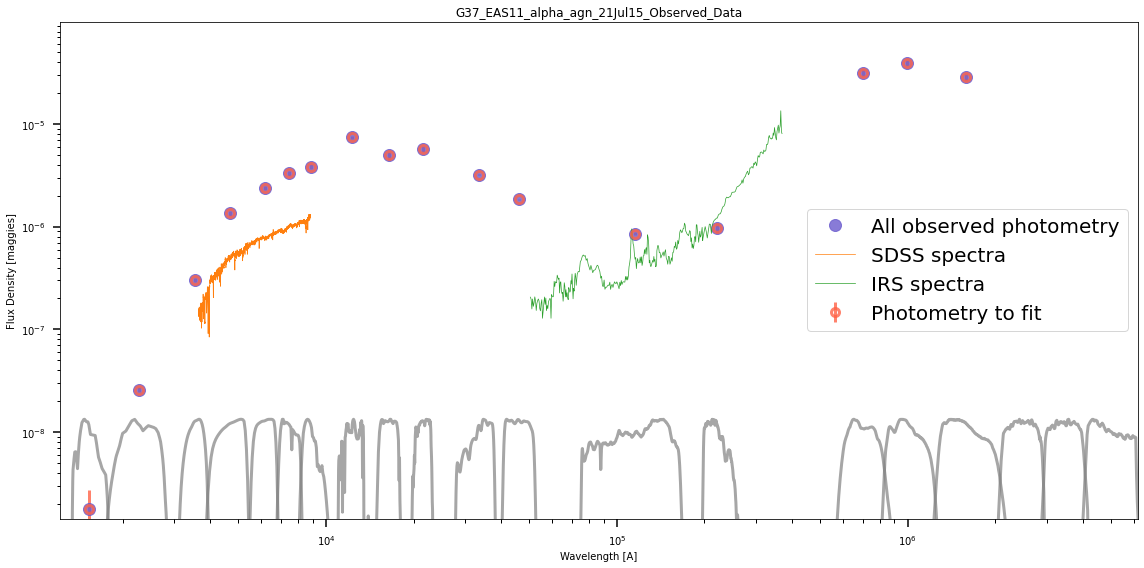

In [16]:
### Plot all observed data ###
# Retreive observed photometry and photometry mask from obs
wphot = obs["phot_wave"]
mask = obs["phot_mask"]

# Set minimum and maximum limits for plot
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
if np.min(obs["maggies"][mask]) <= 0:
    # ymin = sorted(obs["maggies"][mask])[1] * 0.8
    ymin = 10**-10
else:
    ymin = obs["maggies"][mask].min()*0.8 
ymax = obs["maggies"][mask].max()/0.4

figure(figsize=(16,8))

# Plot all observed photometry
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# Overplot only data we want to fit (using phot_mask)
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# Plot filter bands
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
title('{0}_Observed_Data'.format(run_params['ID']))
tight_layout()

In [17]:
# Use PolySpec model to match mismatched photometry/spectroscopy:
#       https://github.com/bd-j/prospector/issues/213
# print(xmin, xmax, ymin, ymax)

In [18]:
### Define agelimits, tilde_alpha, and z_fraction_init for build_model ###
agelims = run_params['agelims']
agelims[-1] = np.log10(tage_of_univ * 1e9)
agebins = np.array([agelims[:-1], agelims[1:]])
ncomp = agebins.shape[1]                              #- 1 Had to modify for array sizes to fit

tilde_alpha = np.array([ncomp - i for i in list(range(1, ncomp))])
z_fraction_init = np.array([(i-1)/float(i) for i in range(ncomp,1,-1)])

# Save prospector compatible arrays to run_params
run_params['ncomp'] = ncomp
run_params['agebins_init'] = agebins.T
run_params['tilde_alpha'] = tilde_alpha
run_params['z_fraction_init'] = z_fraction_init

In [19]:
### Build model and view model ###
model = build_model(**run_params)

# Save number of free parameters and number of data points to run_params
run_params['num_free_params'] = len(model.free_params)
run_params['free_params'] = model.free_params 
run_params['num_data_points'] = len(obs['maggies'][obs["phot_mask"]])

In [20]:
### Build sps object using FracSFH basis ###
sps = build_sps(**run_params)               # Charlie Konroy

/home/emma/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


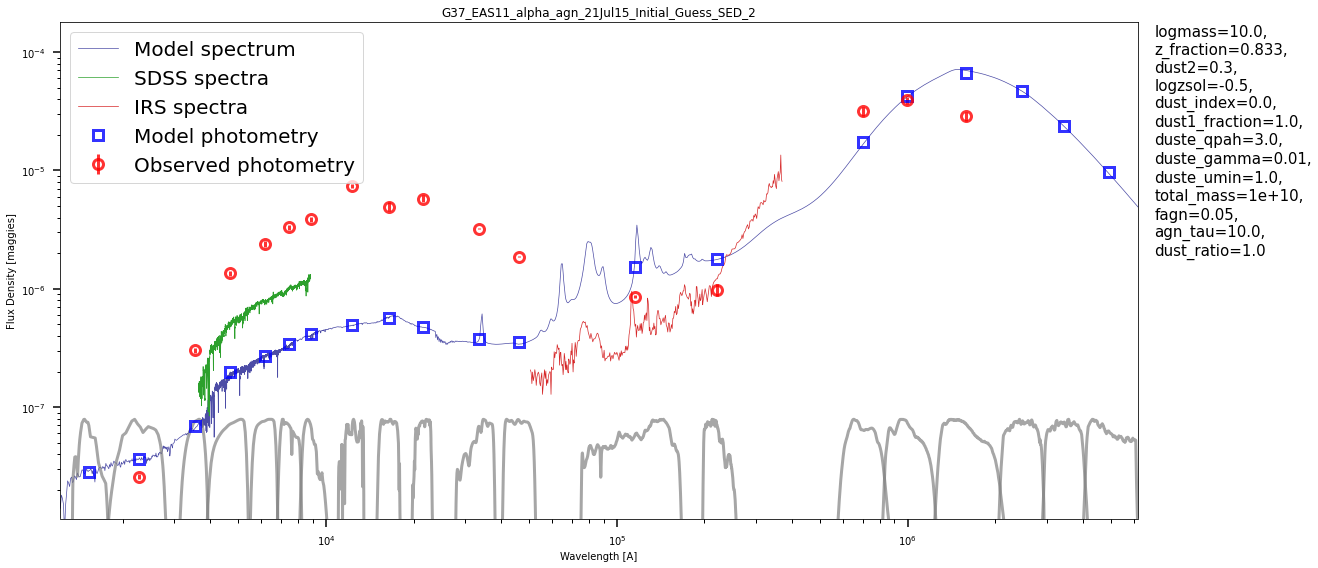

In [21]:
### View Model ###
### prediction for the data from any set of model params ###

### Generate the model SED with the 'init' parameter values in model
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["\n{}={:.3}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
wphot = obs["phot_wave"]                # photometric effective wavelengths

# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a                                          # redshift them

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# Plot model and data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# Place text of all initial model values and title
figtext(1.005, .55, title_text, ha="left", fontsize=15)
title('{0}_Initial_Guess_SED_2'.format(run_params['ID']))

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + '{}_Initial_Guess_SED_2'.format(run_params['ID']))

In [22]:
### Likelyhood Function ###
"""
For nested sampling lnprobfn(theta, nested=True) will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling lnprobfn(theta, nested=False) returns the posterior probability.
"""
# Turn off AGN parameters so that all galaxies can have a Xi2 prediction
run_params['AGN_switch'] = False
run_params['total_mass_switch'] = False

### Running Prospector ###
# Fit the model using chi squared minimization
# Ensemble MCMC sampler around best location from the minimization 

# Run all building functions
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to know which stellar isochrone and spectral library
# print(sps.ssp.libraries)
# help(fit_model)

Total_mass is off
AGN parameters are off


/home/emma/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [23]:
# TemplateLibrary.describe("alpha")             # Describe the template and parameters used

In [24]:
### Minimization ###
# Uses Levenberg-Marquardt, needed parameters in run_params
# requires a likelihood function that returns a vector of chi values
# imported lnprobfn function takes care of chi values to likelyhood

# --- start minimization ---- # 
run_params["emcee"] = False
run_params["optimize"] = True

print('Begin optimization for {}'.format(run_params['ID']))
output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print("Done optmization in {0}m for {1}".format(output["optimization"][1]/60, run_params['ID']))

# Error with galaxy 10, 12: sfr cannot be negative.

Begin optimization for G37_EAS11_alpha_agn_21Jul15


/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


Done optmization in 2.411066277821859m for G37_EAS11_alpha_agn_21Jul15


ind_best =  0
theta_prediction =  [ 1.00528273e+01  8.51371852e-01  8.38735460e-01  7.54078596e-01
  4.66577552e-01  3.87347786e-01  3.14093534e-01  1.89999762e-01
 -1.84222505e-01  1.27327987e+00  2.89152157e+00  9.87405553e-03
  1.75449971e+00  1.00000000e+00]


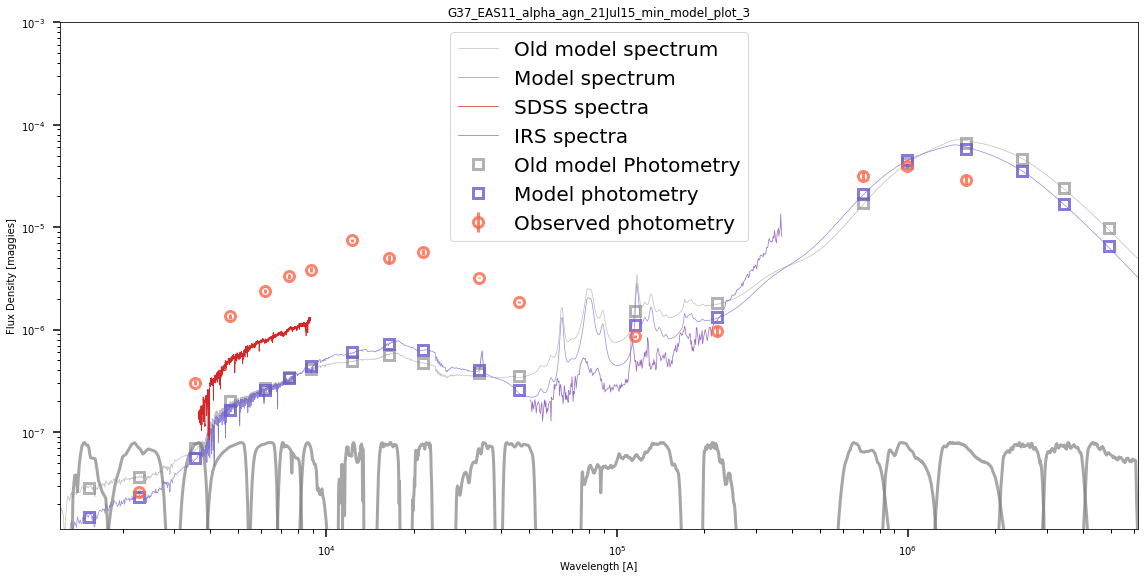

In [25]:
### Plot prediction SED with initial SED ###
# print("Chi2 theta", model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
#       and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print("ind_best = ", ind_best)
theta_prediction = results[ind_best].x.copy()
print("theta_prediction = ", theta_prediction)

figure(figsize=(16,8))                       # Do NOT move

# Generate model prediction
prediction = model.mean_model(theta_prediction, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

# Plot flux data, prediction model, and old init model
loglog(wspec, initial_spec, label='Old model spectrum',
        lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
        marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
        markerfacecolor='none', markeredgecolor='gray', 
        markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
        lw=0.7, color='slateblue', alpha=0.7) 
errorbar(wphot, pphot, label='Model photometry', 
        marker='s', markersize=10, alpha=0.8, ls='', lw=3,
        markerfacecolor='none', markeredgecolor='slateblue', 
        markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
        label='Observed photometry', 
        marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
        ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
        markeredgewidth=3)

# Plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ymax = 10**-3
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

title('{0}_min_model_plot_3'.format(run_params['ID']))
savefig(Galaxy_Path + '{0}_min_model_plot_3'.format(run_params['ID']))


In [26]:
# Turn AGN parameters back on
run_params['AGN_switch'] = True
run_params['total_mass_switch'] = True

# Re-run build functions with AGN
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

print('run_params:')
for i, item1 in enumerate(run_params):
    print(item1, ':\t', run_params[item1])

run_params:
ldist :	 167.84634899645252
agelims :	 [0.0, 8.0, 8.5, 9.0, 9.5, 9.8, 10.121444693271773]
object_redshift :	 0.03954601
zcontinuous :	 1
verbose :	 False
dynesty :	 False
emcee :	 False
optimize :	 True
optimization :	 False
min_method :	 lm
nmin :	 5
nwalkers :	 200
niter :	 500
nburn :	 [150, 200, 200]
nested_method :	 rwalk
nlive_init :	 400
nlive_batch :	 200
nested_dlogz_init :	 0.05
nested_posterior_thresh :	 0.05
nested_maxcall :	 10000000
objname :	 G37_alpha_agn
initial_disp :	 0.1
AGN_switch :	 True
tage_of_univ :	 13.226492599539132
Template_Type :	 alpha_agn
galaxy_num :	 37
SDSS_Query :	        ra              dec               objid        ... run2d instrument
---------------- ---------------- ------------------- ... ----- ----------
242.585332878361 41.8548952207732 1237659329239777432 ...    26       SDSS
total_mass_switch :	 True
gal_desig :	 EAS11
ts :	 21Jul15
ID :	 G37_EAS11_alpha_agn_21Jul15
ra_labels :	 ['16h10m19s', '16h10m20s', '16h10m22s']
dec_label

/home/emma/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [27]:
### Run MCMC with emcee ###
# Generally takes around 20-30 minutes
run_params["optimize"] = False
run_params["emcee"] = True

# --- Run MCMC --- #
print('Start emcee for {}'.format(run_params['ID']))
output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print('done emcee in {0}m for {1}'.format(output["sampling"][1]/60, run_params['ID']))

Start emcee for G37_EAS11_alpha_agn_21Jul15


/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


done emcee in 35.63749053478241m for G37_EAS11_alpha_agn_21Jul15


In [28]:
### Create file path and re-run build functions ###
ts = run_params['ts']                   #time.strftime("%y%b%d", time.localtime())
hfile = Galaxy_Path + '{}_mcmc.h5'.format(run_params['ID'])
obs, model, sps = build_obs(**run_params),  build_model(**run_params), build_sps(**run_params)

In [29]:
### Use to save results to disk ###
writer.write_hdf5(hfile, run_params, model, obs, 
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1],
                  sps=sps)
print('Finished writing h5 file')

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)


RuntimeError: Unable to create attribute (object header message is too large)

In [ ]:
### Load in file that was just saved ###

# Grab results (dictionary), the obs dictionary, and our corresponding models
result, obs, __ = reader.results_from(Galaxy_Path + '{}_mcmc.h5'.format(run_params['ID']), dangerous=False)

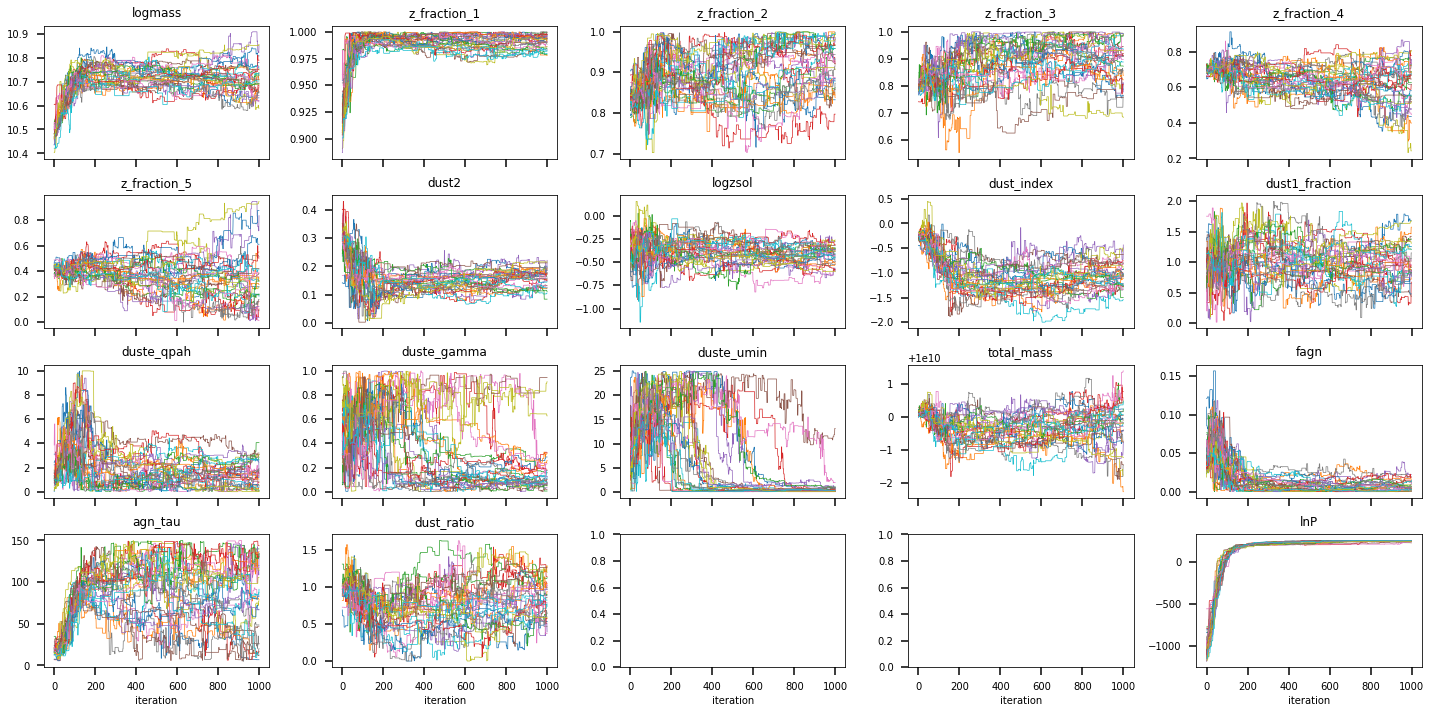

In [ ]:
### Plotting Parameter Traces ###
chosen = np.random.choice(result["run_params"]["nwalkers"], size=30, replace=False)         # Added more traces (50 instead of 10)
tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)

savefig(Galaxy_Path + '{0}_param_trace_4'.format(run_params['ID']))

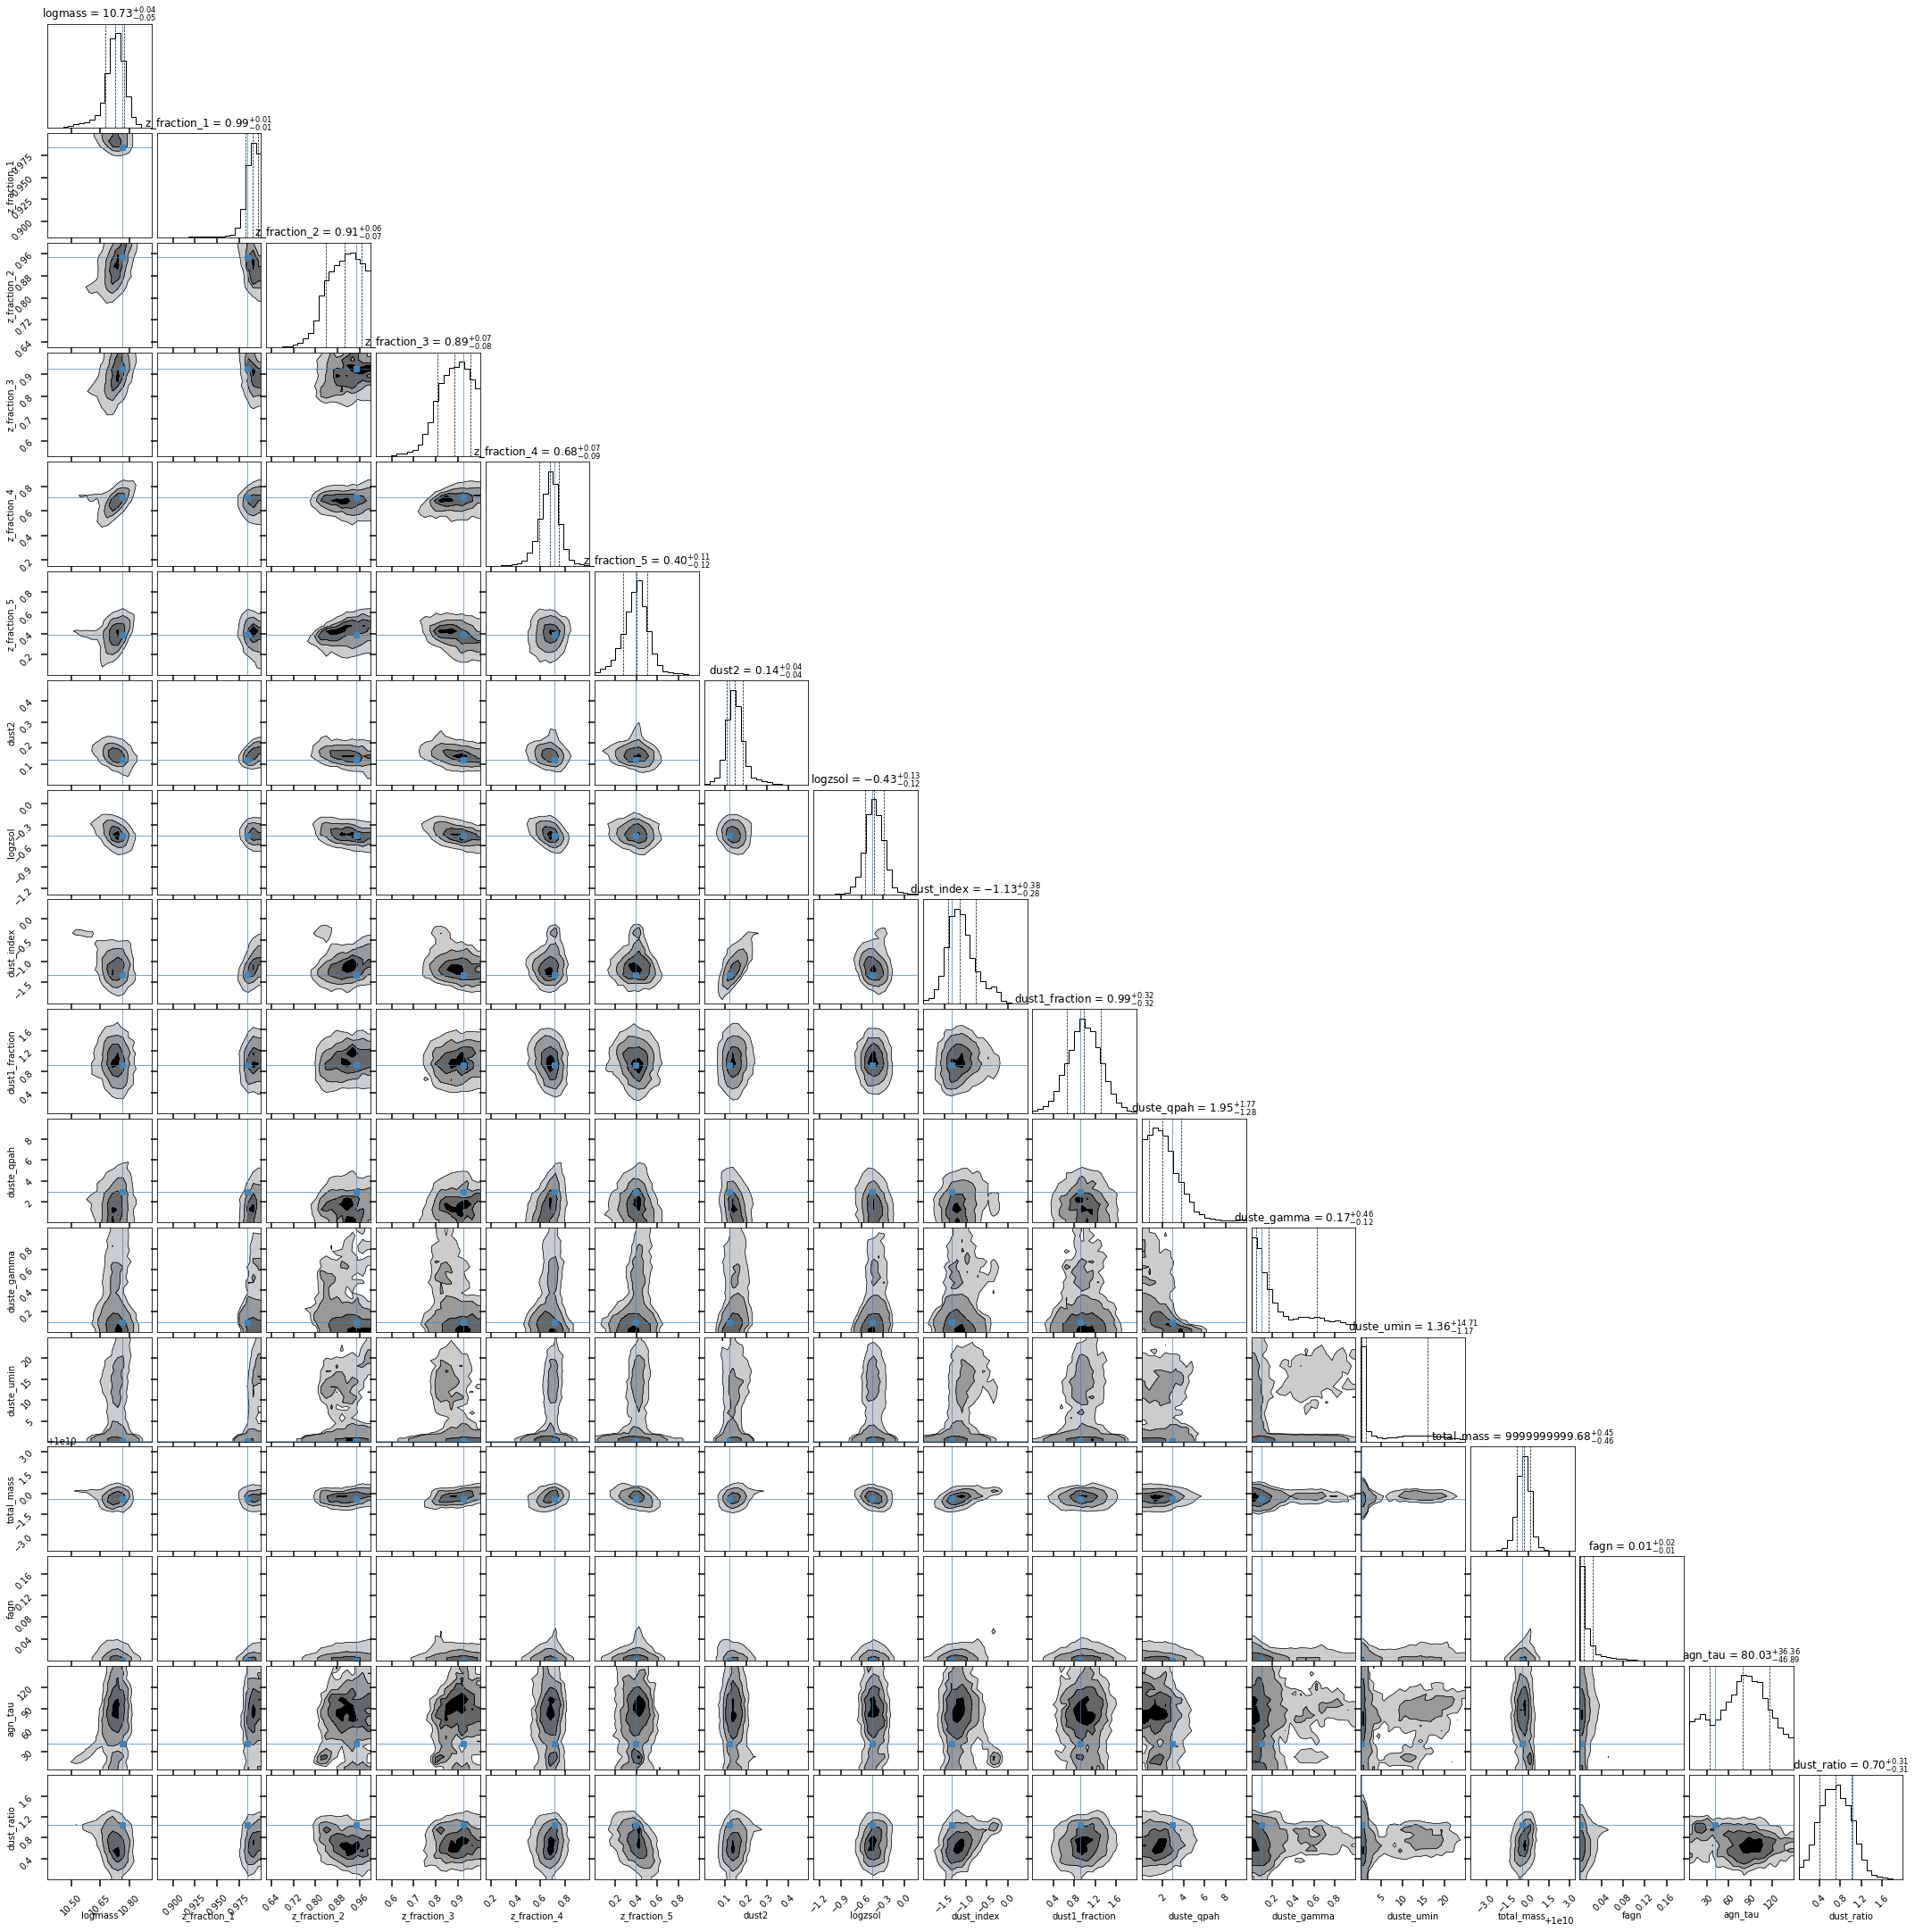

In [ ]:
### Corner Plot ###
# Maximum a posterior (of the locations visited by the MCMC sampler)
theta_bestfit = result['bestfit']['parameter']
cornerfig = reader.subcorner(result, start=0,  truths= theta_bestfit,  
                        fig=subplots(17, 17,figsize=(30,30))[0])       # MUST modify subplot(#,#) thin=thin,

savefig(Galaxy_Path + '{0}_corner_plot_5'.format(run_params['ID']))

In [ ]:
### Create a table of prediction parameters and bestfit parameters ###

print(theta_prediction)
pandas.DataFrame([theta_bestfit], index=['bestfit'], columns=result['theta_labels']).T  # np.linspace(0, len(theta_bestfit)-1, num=len(theta_bestfit))


[ 1.03394744e+01  9.80762109e-01  9.99999969e-01  5.82477190e-01
  1.44332788e-05  1.54991048e-02  1.85018323e-01 -6.10716424e-01
 -1.11847894e+00  1.46830553e+00  1.87484313e+00  8.48652394e-02
  1.25115173e+00  1.00000000e+00]


,bestfit
logmass,1.076075e+01
z_fraction_1,9.843045e-01
z_fraction_2,9.463186e-01
z_fraction_3,9.235883e-01
z_fraction_4,7.130579e-01
z_fraction_5,3.883934e-01
dust2,1.215927e-01
logzsol,-4.601084e-01
dust_index,-1.329948e+00
dust1_fraction,9.213516e-01


In [ ]:
# https://github.com/nolaaa/SED_fitting_Prospecotr/blob/master/7_run_prospector_for_all_arcs.ipynb

In [ ]:
### Plot generated bestfit SED model ###
mspec_map, mphot_map, _ = model.mean_model(theta_bestfit, obs, sps=sps)

In [ ]:
### Calculate reduced χ2 ###
χ2 = np.longdouble(0) # np.float128(0)
χ2_DOF = 0
χ_array = np.zeros(len(wphot))
for i in range(0, len(wphot)):
    unc_variable = np.longdouble(obs['maggies_unc'][i])
    if unc_variable == 0:
        χ2 += 0
        χ_array[i] = np.inf
    else:
        χ= np.longdouble((mphot_map[i] - obs['maggies'][i]))/unc_variable
        χ_array[i] = χ
        χ2 += χ**2
        χ2_DOF += 1

χ_array_mask = [χ_array == np.inf]
print('Reduced χ2 = ',χ2/χ2_DOF, '\nDOF = ', χ2_DOF)

Reduced χ2 =  0.8970369585478217787 
DOF =  20


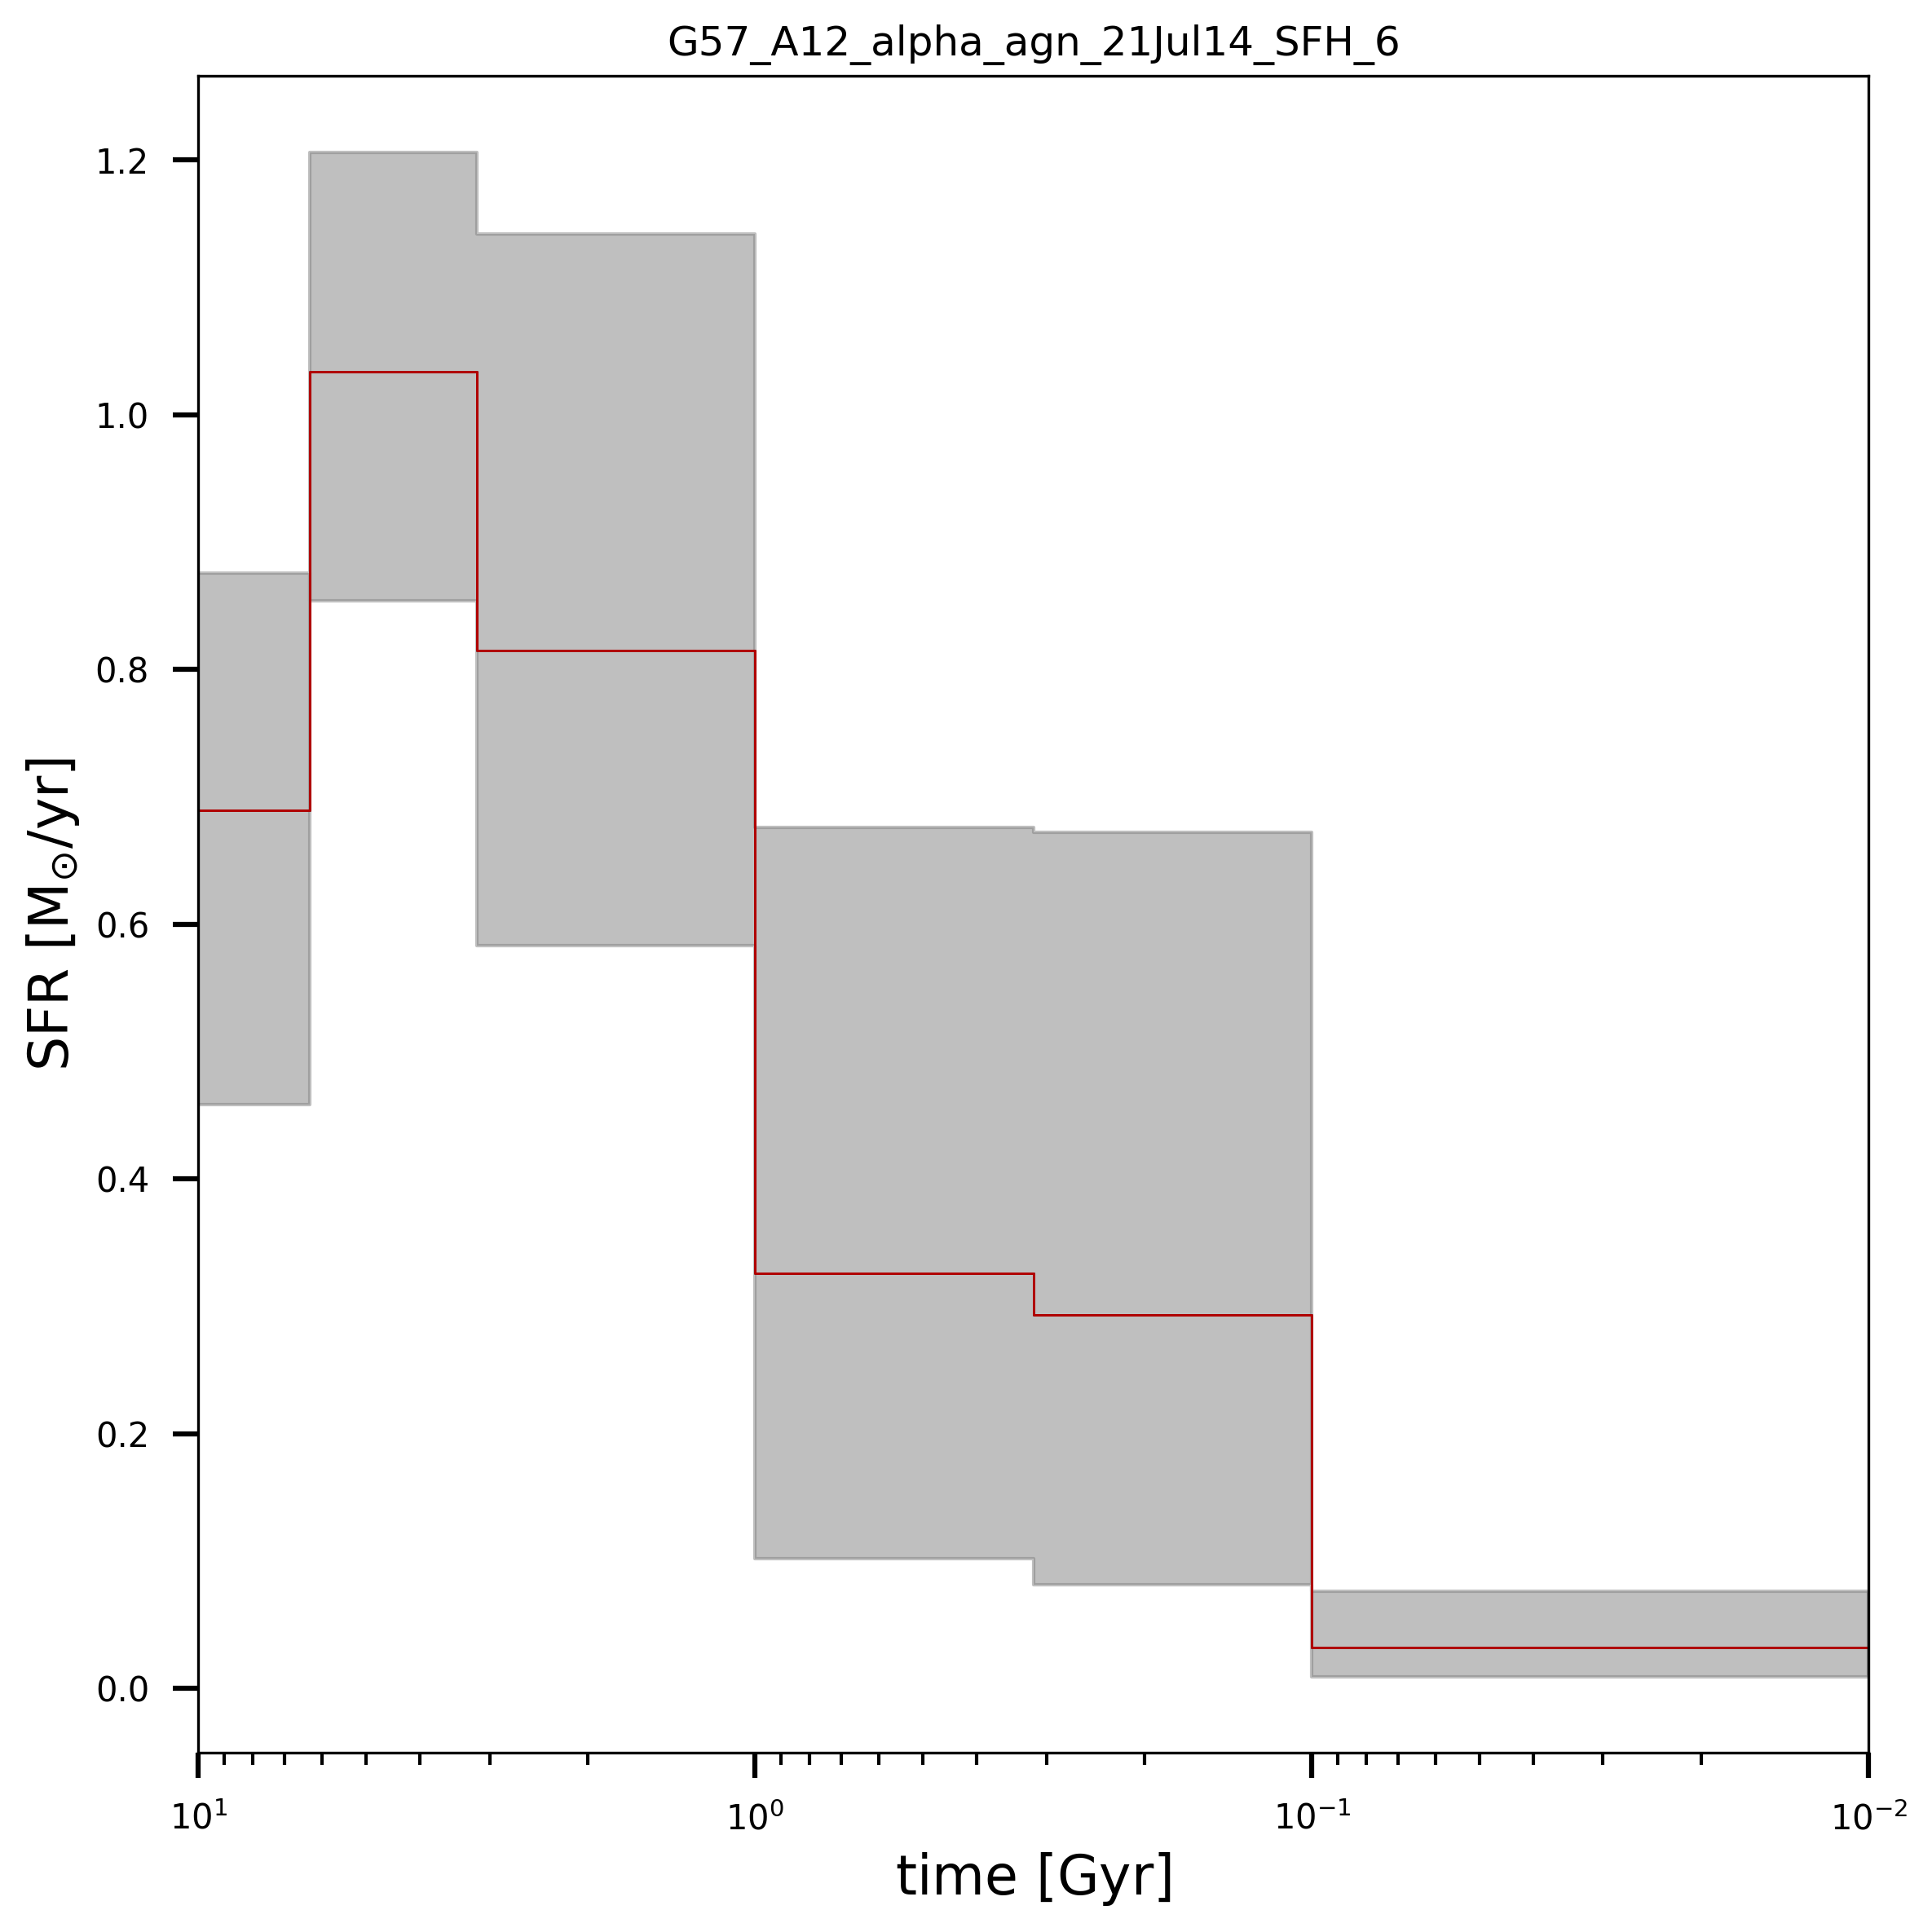

In [ ]:
chain_shape = result['chain'].shape

if result['chain'].ndim > 2:
    flatchain = result['chain'].reshape(chain_shape[0] * chain_shape[1], chain_shape[2])

# Convert agelims to GYR and make first element nonzero
age_GYR = np.power(10, result['run_params']['agelims'])/1e9       # agebins in GYR
age_GYR[0] = 1e-2                                       # Make first element nonzero to avoid squishing plot

sfh_agebins = result['run_params']['agebins_init']
theta_labels = result['theta_labels']

# Pull out zfraction elements from theta_labels
zfrac_list=np.array([])
for label in range(0, len(theta_labels)):
    if theta_labels[label][:10] == 'z_fraction':
        zfrac_list = np.append(zfrac_list, label)

zfrac_list = zfrac_list.astype(int).tolist()
z_frac_num = np.array([theta_labels[i] for i in range (len (theta_labels)) if i in zfrac_list])

# Create a array of indicies from number of z_fractions
id_zfrac=np.nonzero(z_frac_num)[0]             

# Fill empty arrays with quantile values and bestfit theta
q_50 = np.empty(len(id_zfrac))
dx_up = np.empty(len(id_zfrac))
dx_down = np.empty(len(id_zfrac))
z_frac_bestfit = np.empty(len(id_zfrac))
for i in id_zfrac:
    q_50[i], dx_up[i], dx_down[i] = best_vals(flatchain.T[i+1])
    z_frac_bestfit[i] = theta_bestfit[i+1]

# Define zfrac array and top and bottom limits
z_frac = q_50
z_frac_upper = q_50 + dx_up
z_frac_lower = q_50 - dx_down

# Find total mass for zfrac_to_sfr
total_mass_q50 = best_vals(flatchain.T[13])[0] 
total_mass_bestfit = theta_bestfit[13] 

# Convert zfractions to sfr
sfr_quant = zfrac_to_sfr(total_mass_q50, z_frac, sfh_agebins)               # use logmass?
sfr_upper_quant = zfrac_to_sfr(total_mass_q50, z_frac_upper, sfh_agebins)
sfr_lower_quant = zfrac_to_sfr(total_mass_q50, z_frac_lower, sfh_agebins)
ssfr_quant = sfr_quant/total_mass_q50

sfr_bestfit = zfrac_to_sfr(total_mass_bestfit, z_frac, sfh_agebins)
ssfr_bestfit = sfr_bestfit/total_mass_bestfit

# Create the figure
fig = figure(figsize=(8, 8), dpi = 300) #, dpi = 250)
ax=fig.add_subplot(1,1,1)

# Append last element to array to see full sfr in plot
sfr1_q = np.append(sfr_quant, sfr_quant[-1])                   
sfr_upper_q1 = np.append(sfr_upper_quant, sfr_upper_quant[-1])
sfr_lower_q1 = np.append(sfr_lower_quant, sfr_lower_quant[-1])
sfr1_bestfit = np.append(sfr_bestfit, sfr_bestfit[-1])

# Plot SFR in a step function and fill quantiles
step(age_GYR, sfr1_q, where='post', color='k')
step(age_GYR, sfr1_bestfit, where='post', color='r', alpha=0.7)
fill_between(age_GYR, sfr_lower_q1, sfr_upper_q1, color='gray', step='post', alpha=0.5)

xscale('log')
ylabel(r'$\rm{SFR\ [M_{\odot}/yr]}$', fontsize=16)
xlabel(r'$\rm{time\ [Gyr]}$', fontsize=16)
xlim(10, 1e-2)

title('{0}_SFH_6'.format(run_params['ID']))

tight_layout()

savefig(Galaxy_Path + '{0}_SFH_6'.format(run_params['ID']))

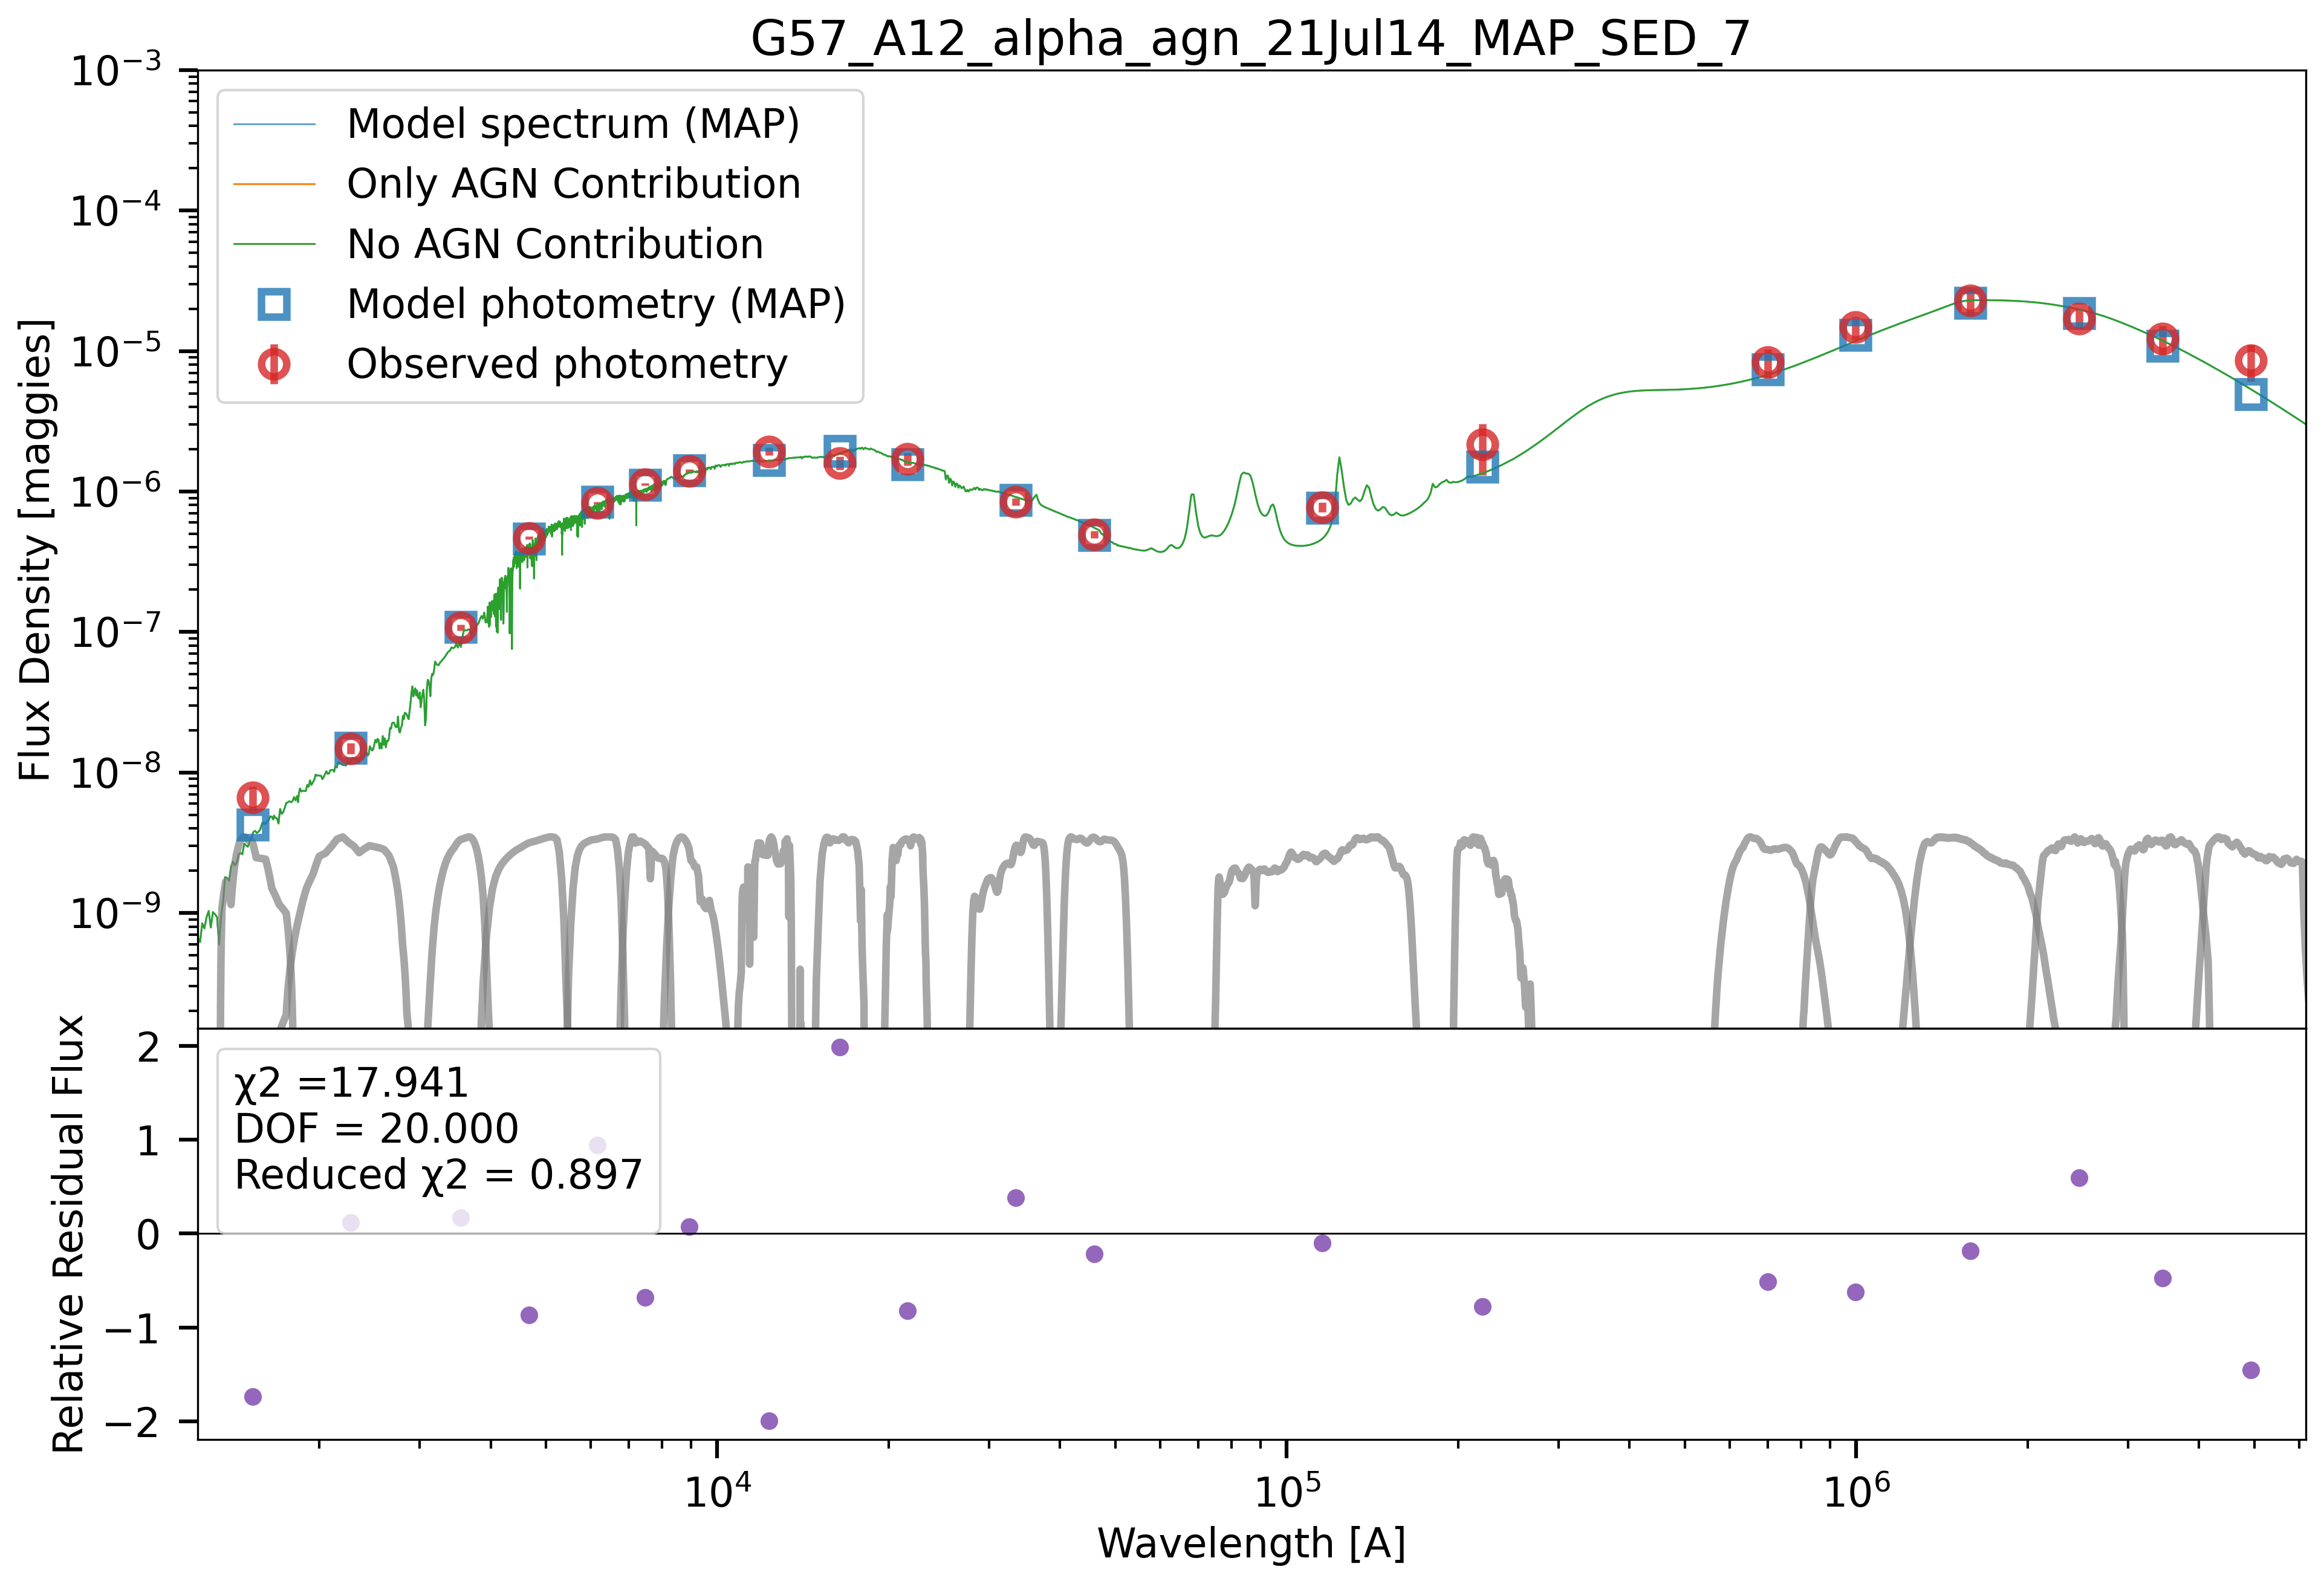

In [ ]:
# https://github.com/bd-j/prospector/issues/186
rcParams.update({'font.size':'16'})
ymin = 1.5 * (10**-10)

# Make plot of data and model
fig1 = figure(figsize=(15,10), dpi=300)

ax = [0,0]
grid = GridSpec(10, 1, hspace=0)
ax[0] = subplot(grid[:7, :1])
ax[1] = subplot(grid[7:, :1])


ax[0].loglog(wspec * (1 + model.params['zred']), mspec_map, label='Model spectrum (MAP)',
        lw=0.7,  alpha=0.7, color = my_cmap[0]) 
ax[0].errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', color = my_cmap[0], markeredgewidth=3) 
ax[0].errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor= my_cmap[3], 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor=my_cmap[3], 
         markeredgewidth=3)

### AGN Emission Contribution ###
agn_only_theta = theta_bestfit.copy()
agn_only_theta[13] = 0
mspec_agn_inv, mphot_agn_inv, mextra = model.mean_model(agn_only_theta, obs, sps=sps)
mspec_agn = mspec_map - mspec_agn_inv
ax[0].loglog(wspec * (1 + model.params['zred']), mspec_agn, label='Only AGN Contribution', color = my_cmap[1]) #, color='orange'

### No AGN Contribution ###
ax[0].loglog(wspec * (1 + model.params['zred']), mspec_agn_inv, label='No AGN Contribution', color = my_cmap[2])  #, color='purple'

# Plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    ax[0].loglog(w, t, lw=3, color='gray', alpha=0.7)

# https://github.com/bd-j/prospector/blob/main/demo/InteractiveDemo.ipynb 
# https://github.com/kaiwen-kakuiii/Prospector-alpha-2018/blob/master/Prospector-alpha.ipynb
# https://github.com/bd-j/prospector/blob/a0d41ab59b2ba96e01c4a744437cbe37c0319cc7/demo/tutorial.rst 

ax[0].set_ylabel('Flux Density [maggies]')
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([ymin, ymax])
ax[0].legend(loc='best')
ax[0].set_title('{0}_MAP_SED_7'.format(run_params['ID']))

ax[1].scatter(np.ma.masked_array(wphot, mask=χ_array_mask).compressed(), 
     χ_array[np.invert(χ_array_mask)[0]], color=my_cmap[4])
ax[1].plot(np.logspace(np.log10(wphot.min()) * 0.8, np.log10(wphot.max()) * 1.2, len(wphot)), np.zeros(len(wphot)), 'k-') 
ax[1].set_xscale('log')
ax[1].set_ylabel('Relative Residual Flux')
ax[1].set_xlabel('Wavelength [A]')

ax[1].set_xlim([xmin, xmax])
ax[1].legend(title=f'χ2 ={χ2:.3f}\nDOF = {χ2_DOF:.3f}\nReduced χ2 = {χ2/χ2_DOF:.3f}', loc=2)

fig1.subplots_adjust(hspace=0)   

savefig(Galaxy_Path + '{0}_MAP_SED_7'.format(run_params['ID']))

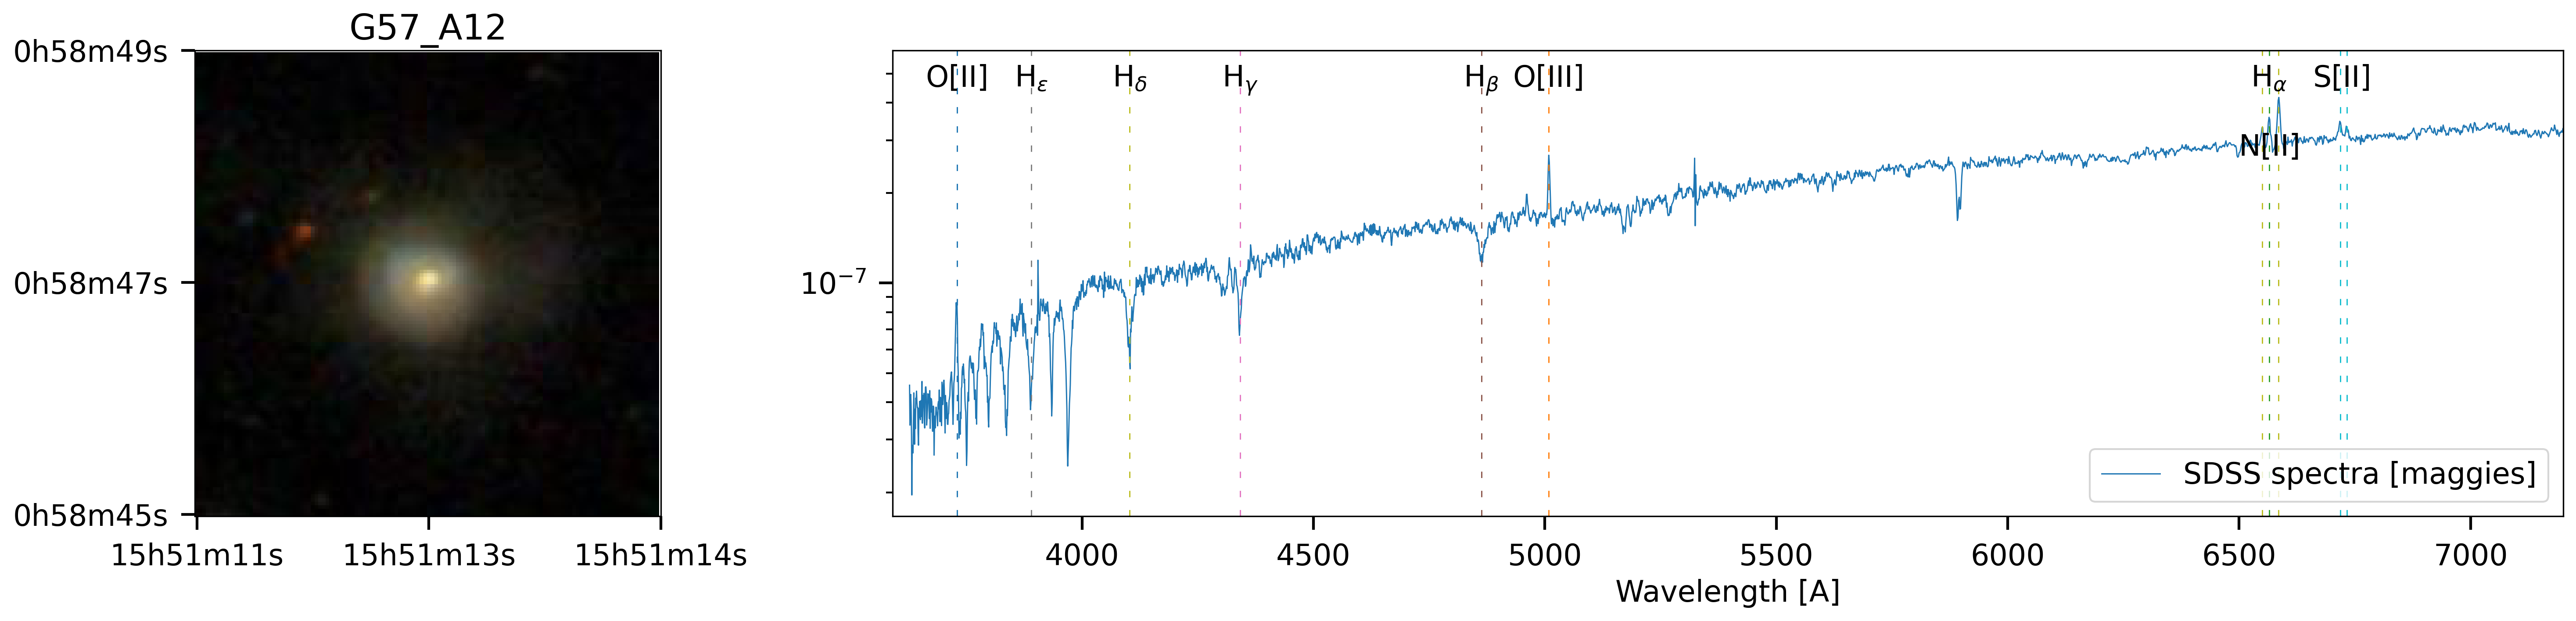

In [ ]:
fig1 = figure(figsize=(20,5), dpi = 300)

grid = GridSpec(2, 7)

if IRS_indicator == 1:
    ax1 = subplot(grid[:2, :2])
    ax2 = subplot(grid[0, 2:7])
    ax3 = subplot(grid[1, 2:7])
else:
    ax1 = subplot(grid[:2, :2])
    ax2 = subplot(grid[0:, 2:7])

ax1.imshow(SDSS_Image, origin='lower')
ax1.set_xticks([0, SDSS_width/2, SDSS_width])
ax1.set_xticklabels([ra_left_str, ra_center_str, ra_right_str])
ax1.set_yticks([0, SDSS_width/2, SDSS_width])
ax1.set_yticklabels([dec_left_str, dec_center_str, dec_right_str])
ax1.set_title('G{0}_{1}'.format(run_params['galaxy_num'], run_params['gal_desig']))


# Plot optical and IRS data if available
ax2.plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra [maggies]')
y_min, y_max = ax2.get_ylim()

spec_lines = ['[O_II] 3727', '[O_III] 5007', 'H_alpha', '[N_II] 6548', '[N_II] 6583', 'H_beta', 'H_gamma', 'H_epsilon', 'H_delta', '[S_II] 6716', '[S_II] 6730']
spec_lines_short = [r'O[II]', r'O[III]', r'H$_α$', r'N[II]', r'N[II]', r'H$_β$', r'H$_γ$', r'H$_ε$', r'H$_δ$', r'S[II]', r'S[II]']
for i, n in enumerate(spec_lines):
    if (n =='[N_II] 6548' or n =='[N_II] 6583'):
        ax2.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n],  color=my_cmap[8], ymax = 1, ymin = 0, linestyle=(0, (5, 10))) 
        if n =='[N_II] 6548':
            ax2.annotate(spec_lines_short[i], ((6548 + 6583)/2, y_max* 0.5), horizontalalignment='center')
    elif (n =='[S_II] 6716' or n =='[S_II] 6730'):
        ax2.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n], color=my_cmap[9], ymax = 1, ymin = 0, linestyle=(0, (5, 10))) 
        if n == '[S_II] 6716':
            ax2.annotate(spec_lines_short[i], ((6716 + 6730)/2, y_max* 0.85), horizontalalignment='center')
    else:
        ax2.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n],  color=my_cmap[i], ymax = 1, ymin = 0, linestyle=(0, (5, 10)))
        ax2.annotate(spec_lines_short[i], (optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n], y_max* 0.85), horizontalalignment='center')

ax2.set_xlim(min(optical_spectrum_lam) * .99, 7200)
ax2.set_xlabel('Wavelength [A]')
ax2.set_yscale('log')
ax2.legend(loc=4)

if IRS_indicator == 1:
    ax3.plot(IRS_wavelength, IRS_flux, label='IRS spectra [maggies]')
    ax3.set_xlabel('Wavelength [A]')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.legend(loc=4)

tight_layout()

savefig(Galaxy_Path + '{0}_SDSS_Img_Spectra'.format(run_params['ID']))


In [ ]:
end_time = time.time()
print('Finished running {}'.format(run_params['ID']))
print('This program takes:\n\t',end_time - start_time, '\tsecs\n\t', (end_time - start_time)/60, '\tmins\n\t', (end_time - start_time)/60/60, '\thours')

Finished running G57_A12_alpha_agn_21Jul14
This program takes:
	 7584.678784370422 	secs
	 126.41131307284037 	mins
	 2.106855217880673 	hours
